### The general idea

Before diving into developing or deploying an endpoint for semantic routing, it’s important to understand the core concepts of what we aim to achieve.

Embedding models are a type of AI model designed to convert data — such as text — into another representation, i.e., a vector with numeric representation. Each piece of data (for example, a sentence) is mapped to a point in an n-dimensional space. The primary goal of these models is to position similar pieces of data close together in this high-dimensional space, while placing dissimilar items further apart. This property enables us to measure and compare “semantic similarity” between texts. One common example:

- The phrases “yellow cat” and “grey dog” are both mammals and will be embedded relatively close to each other.
- The phrase “grey rock” is quite different, but still shares the attribute “grey” with “grey dog,” so it may be positioned closer to “grey dog” than to “yellow cat.”

Lets see how this can look like in a real scenario.

Side note: most Retrieval Augmented Generation (RAG) pipelines using vector database use this idea. 

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [13]:
# Dataset source: https://www.kaggle.com/datasets/rmisra/news-category-dataset
data = pd.read_json("./../data/News_Category_Dataset_v3.json", lines=True)
print(f"Original dataset loaded with {data.shape[0]} rows and {data.shape[1]} columns.")

Original dataset loaded with 209527 rows and 6 columns.


In [14]:
# Keep only columns where category is "Business", "Comedy" or "Science".
data = data[data['category'].isin(filter_categories := ['BUSINESS', 'COMEDY', 'SCIENCE'])]
print(f"Filtered dataset to {data.shape[0]} rows with categories {filter_categories}.")

Filtered dataset to 13598 rows with categories ['BUSINESS', 'COMEDY', 'SCIENCE'].


In [15]:
# For demonstration purposes, we limit the size of the dataset but keeping the same number of samples per category.
n_keep = 500
data = data.groupby('category').head(n_keep).reset_index(drop=True).drop(columns=["link", "date"])
print(f"Size of dataset reduced to {data.shape[0]} rows.")

data.head()

Size of dataset reduced to 1500 rows.


,headline,category,short_description,authors
0,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel
1,Fuel Leak Ruins NASA's 2nd Shot At Launching N...,SCIENCE,"Part of the space agency's Artemis program, th...","Marcia Dunn, AP"
2,'Safety Is Always First': NASA Reschedules Art...,SCIENCE,"“We’re going to play all nine innings here,” t...",Nick Visser
3,REI Workers At Berkeley Store Vote To Unionize...,BUSINESS,They follow in the footsteps of REI workers in...,Dave Jamieson
4,Chinese Rocket Debris Makes Out-Of-Control Fal...,SCIENCE,Video shows people apparently spotting the roc...,Ben Blanchet


In [16]:
# all-MiniLM-L6-v2 is a lightweight model that maps sentences & paragraphs to a 384 dimensional dense vector space.
# In 'dense' vectors, most or all elements are non-zero and carry meaningful values, contrasting with 'sparse' vectors which mostly contain zeros.

# This model is efficient for tasks like semantic search, clustering, and classification.
embedding_model_name = "all-MiniLM-L6-v2"
embedding_model = SentenceTransformer(embedding_model_name)

In [17]:
# Generate embeddings for the headlines and descriptions
data["headline_embedding"] = data["headline"].apply(lambda x: embedding_model.encode(x, convert_to_numpy=True))

In [18]:
# Lets check whether we can actually determine the category of a headline based on its embedding. 
# To visualize the embeddings, we first need to reduce their dimensionality, otherwise visualizing high-dimensional data will be impractical. 
# We will use the algorithm 't-SNE' for this purpose.
# t-SNE is a technique for dimensionality reduction that is particularly well-suited for visualizing high-dimensional data.
tsne_n_components = 2
tsne = TSNE(n_components=tsne_n_components, random_state=1337)

# Take list/series of 1D arrays (embedding vectors) and combine them into a 2D array (matrix)
headline_embeddings = np.vstack(data['headline_embedding'].values)
headline_embeddings_reduced_dim = tsne.fit_transform(headline_embeddings)

# Add the reduced dimensions to the DataFrame
data['headline_embedding_dim_reduced'] = list(headline_embeddings_reduced_dim)

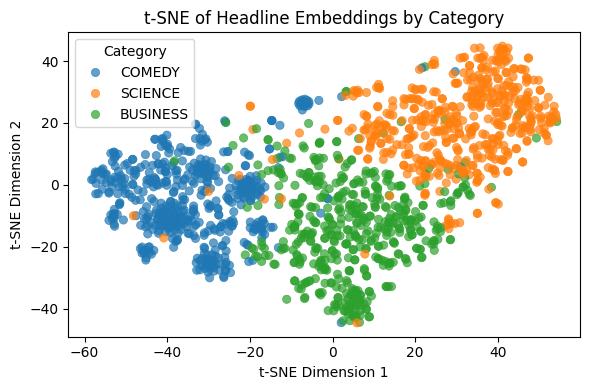

In [19]:
# We can clearly see that the categories are separated. 
# There are some overlaps, but overall the clusters seem to be distinct.
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=data['headline_embedding_dim_reduced'].apply(lambda x: x[0]),
    y=data['headline_embedding_dim_reduced'].apply(lambda x: x[1]),
    hue=data['category'],
    alpha=0.7,
    edgecolor=None
)
plt.title("t-SNE of Headline Embeddings by Category")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Category')
plt.tight_layout()
plt.show()

In [20]:
# Intuition is good, now we can apply a clustering algorithm to the reduced dimensions to see if we can automatically group 
# the headlines into their respective categories. We will use k-means clustering for this purpose.
# K-means is a popular clustering algorithm that partitions data into k distinct clusters based on feature similarity.
n_clusters = data['category'].nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(headline_embeddings_reduced_dim)
data['cluster'] = clusters

# Prepare a mesh grid to draw decision boundaries
x_min, x_max = headline_embeddings_reduced_dim[:,0].min() - 1, headline_embeddings_reduced_dim[:,0].max() + 1
y_min, y_max = headline_embeddings_reduced_dim[:,1].min() - 1, headline_embeddings_reduced_dim[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

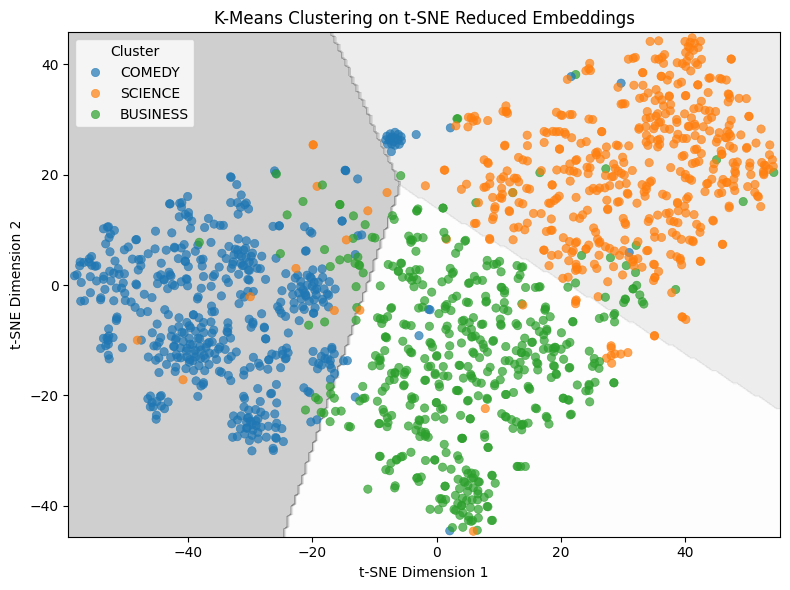

In [21]:
# Plot clusters with boundaries. We can see that the clusters are not perfectly aligned with the categories, but they are reasonably close.
# Note that there are some overlaps, which is expected since the categories are not perfectly separable (e.g., see the blue point cluster at the top).
# This is common in real-world data, but should be optimized further with more data or better feature engineering.
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.2, cmap='Greys')

sns.scatterplot(
    x=data['headline_embedding_dim_reduced'].apply(lambda x: x[0]),
    y=data['headline_embedding_dim_reduced'].apply(lambda x: x[1]),
    hue=data['category'],
    alpha=0.7,
    edgecolor=None
)
plt.title("K-Means Clustering on t-SNE Reduced Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [22]:
# We wil now evaluate the clustering performance using two metrics:

# 1. Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters. 
#    A higher score indicates better-defined clusters.
#    https://www.sciencedirect.com/topics/computer-science/silhouette-coefficient    

# 2. Adjusted Rand Index: Measures the similarity between the true labels and the predicted clusters.
#    When both the clusters are totally different then the value of ARI is −1 and when both the clusters are completely similar then the value of ARI is +1
#    https://www.sciencedirect.com/topics/computer-science/adjusted-rand-index#:~:text=The%20Adjusted%20Rand%20Index%20(ARI,of%20data%20points%20to%20clusters.

# encode true categories as integers
true_labels = data['category'].astype('category').cat.codes

# evaluate clustering
sil = silhouette_score(headline_embeddings_reduced_dim, data['cluster'])
ari = adjusted_rand_score(true_labels, data['cluster'])

print(f"Silhouette Score: {sil:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")

Silhouette Score: 0.476
Adjusted Rand Index: 0.773


The **silhouette score** measures how similar each point is to its own cluster compared to other clusters. It ranges from –1 to 1.

The **Adjusted Rand Index (ARI)** quantifies the agreement between your clustering and the true category labels, adjusted for chance. It ranges from –1 to 1.

| Metric         | Value  | Interpretation                                        |
| -------------- | ------ | ----------------------------------------------------- |
| Silhouette     | 0.476  | Good cluster cohesion and separation (reasonable, but not exceptional) |
| Adjusted Rand  | 0.773  | Strong agreement with true labels                     |


### In summary: this project's goal

By leveraging embeddings, we can cluster or route data based on semantic meaning rather than relying solely on exact matches or keywords. This technique enables us to define flexible and meaningful categories, such as identifying clusters like “toxic language” versus “other” to detect harmful content. Compared to full-scale Large Language Models (LLMs), this approach is much more computationally efficient and is widely used as a guardrail or pre-filter in LLM pipelines.

In this project, we apply semantic clustering to classify sentences into predefined topic clusters. The resulting classifications can then be used for downstream tasks such as content moderation, targeted processing, or custom routing within your application architecture. 
